# **Feature Engineering Notebook**

## Objectives

* Engineer features for Classification model

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Generate a list with variables to engineer

## Conclusions

* xxx


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cd-prediction-pp5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/cd-prediction-pp5'

# Load Cleaned Data

* Train set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,57,0,0,180,517.0,0,1,191,0,1.9,3,3,1
1,58,0,0,135,201.0,0,1,190,1,1.8,1,0,0
2,21,0,0,139,213.0,0,1,71,1,2.3,1,1,0


* Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,25,0,1,197,351.5,0,0,195,0,1.0,3,0,1
1,79,1,1,185,351.5,0,0,138,0,1.6,2,1,1
2,47,0,2,129,186.0,0,2,191,1,3.2,3,0,1


---

## Data Exploration

* We are interested in evaluating which potential transformation you could do in your variables

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

## Correlation and PPS Analysis

* We don’t expect major changes compared to the data cleaning notebook since the only data difference is the removal of “patientid” and changing 'serumcholesterol' 0 values to median values

---

## Feature Engineering

Custom functions user for the feature engineering process.

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

---

### Feature Engineering Spreadsheet Summary

<img src="../static/images/feat-eng-spreadsheet.png" alt="feature engineering spreadsheet" height="400" />

Above, you can see the Feature Engineering Transformers that we will use. To run these transformers, we have to follow four steps:

* Step 1: Select variable(s)
* Step 2: Create a separate dataframe with your variable(s)
* Step 3: Create engineered variables(s), apply the transformation(s), assess engineered variables distribution and select the most suitable method for each variable
* Step 4 - Apply the selected transformation to the Train and Test set

### Categorical Encoding

All categorical variables expressed in binary so no action here.

### Numerical Transformation

By using Numerical Transformation, we are trying to normalize the data by making it less skewed, creating a more even distribution of the underlying data and making it more symmetrical.

* Step 1: Select variable(s)

In [8]:
variables_engineering = ['age',
                    'restingBP',
                    'serumcholestrol',
                    'maxheartrate',
                    'oldpeak',
                    'noofmajorvessels']
variables_engineering

['age',
 'restingBP',
 'serumcholestrol',
 'maxheartrate',
 'oldpeak',
 'noofmajorvessels']

* Step 2: Create a separate dataframe, with your variable(s)

In [9]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

,age,restingBP,serumcholestrol,maxheartrate,oldpeak,noofmajorvessels
0,57,180,517.0,191,1.9,3
1,58,135,201.0,190,1.8,0
2,21,139,213.0,71,2.3,1
3,50,160,310.0,165,0.3,2
4,75,193,417.0,184,3.2,2


* Step 3: Create engineered variables(s) apply the transformation(s), assess engineered variables distribution and select most suitable method

* Variable Analyzed: age
* Applied transformation: ['age_log_e', 'age_log_10', 'age_reciprocal', 'age_power', 'age_box_cox', 'age_yeo_johnson'] 



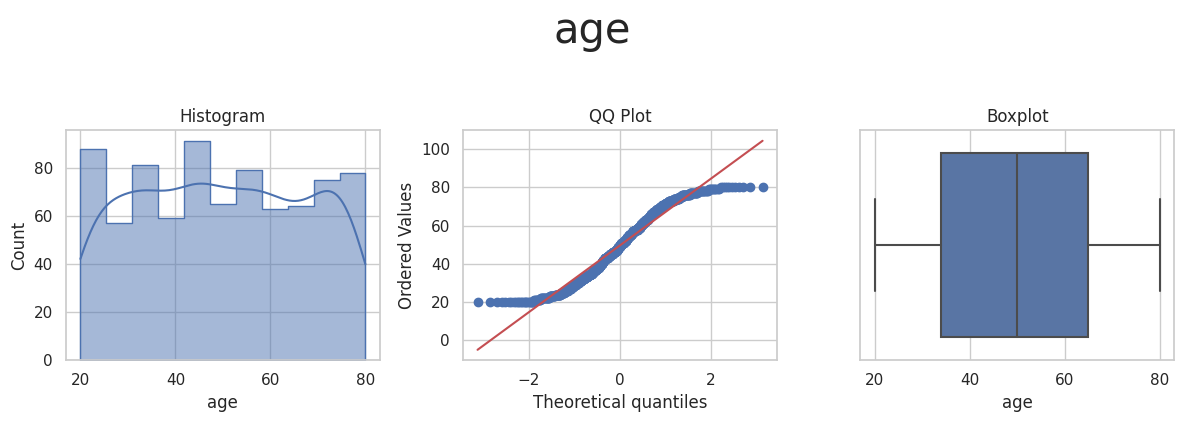

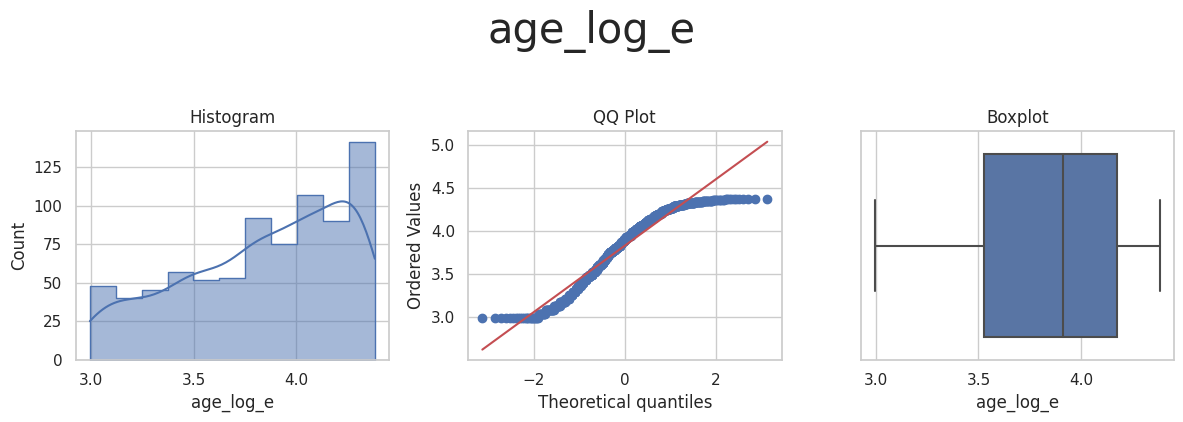

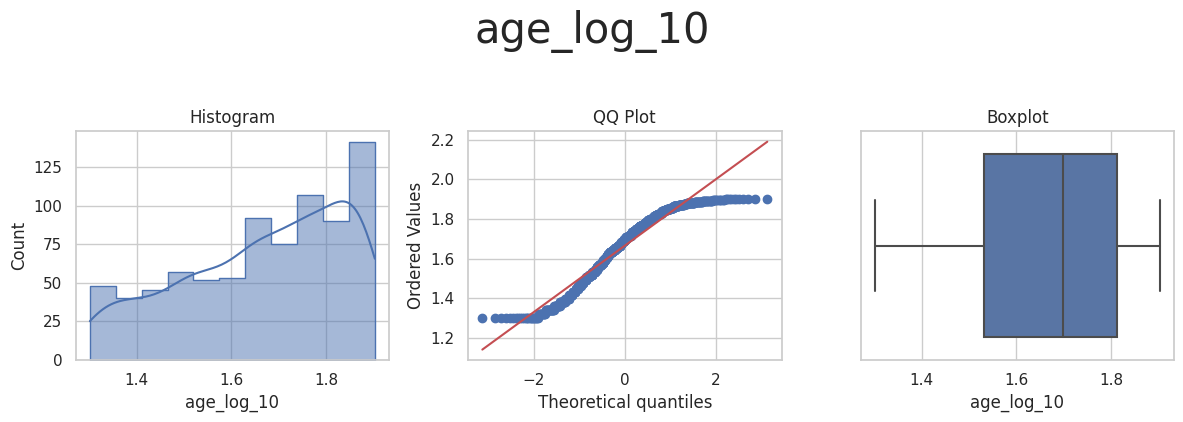

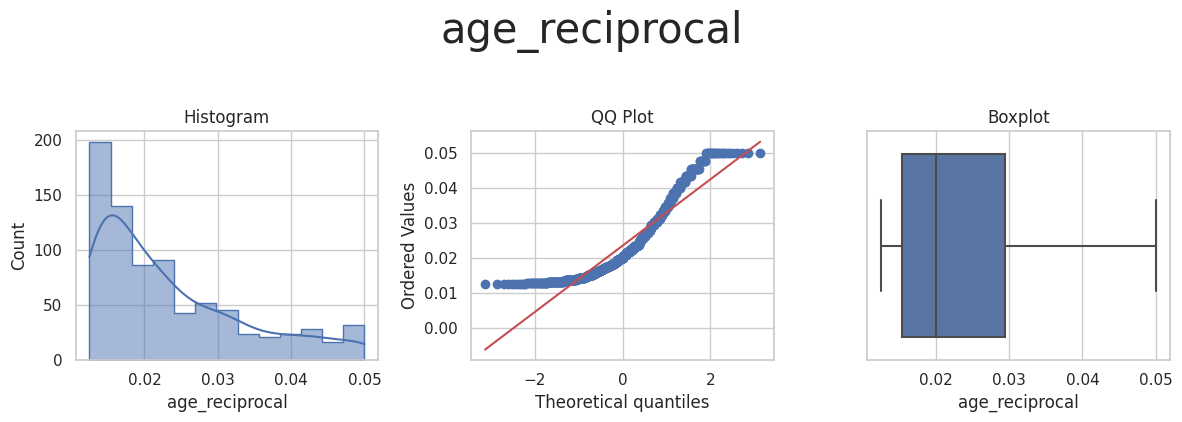

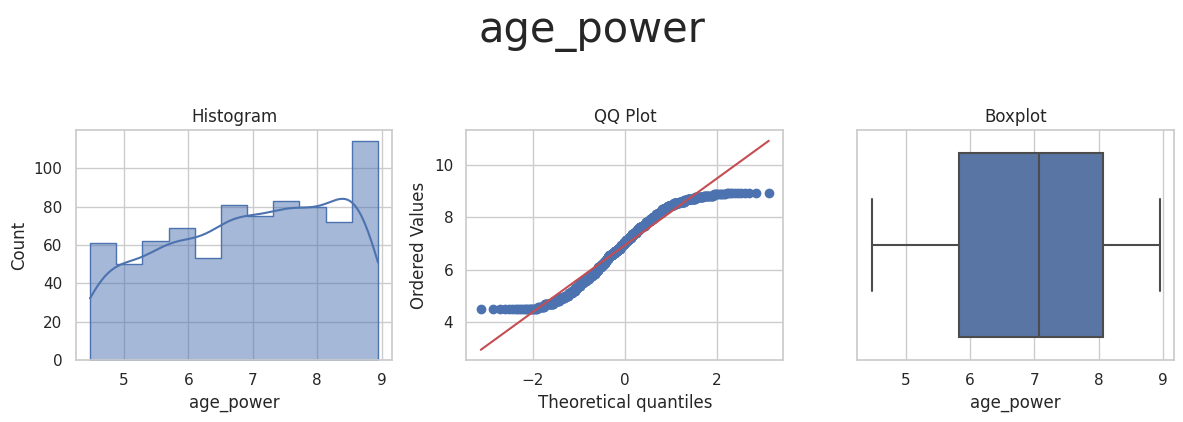

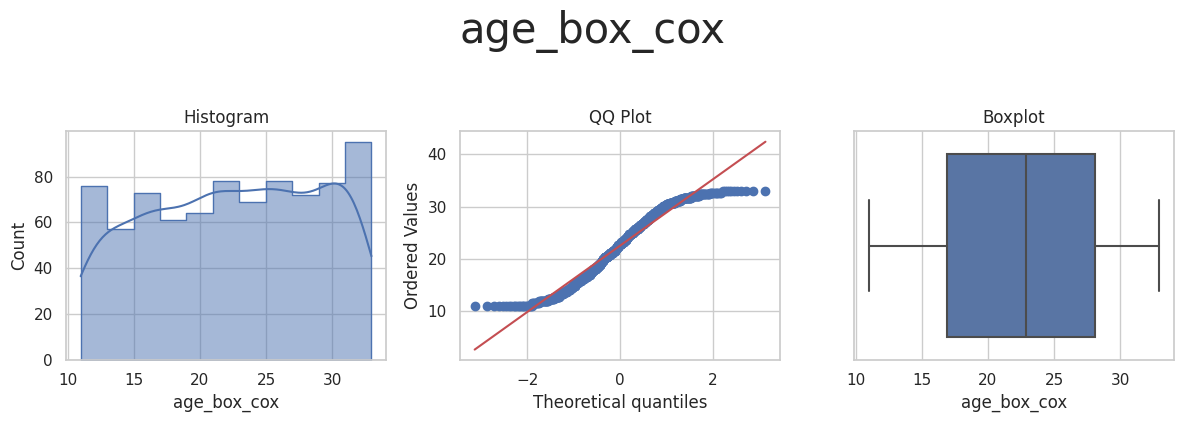

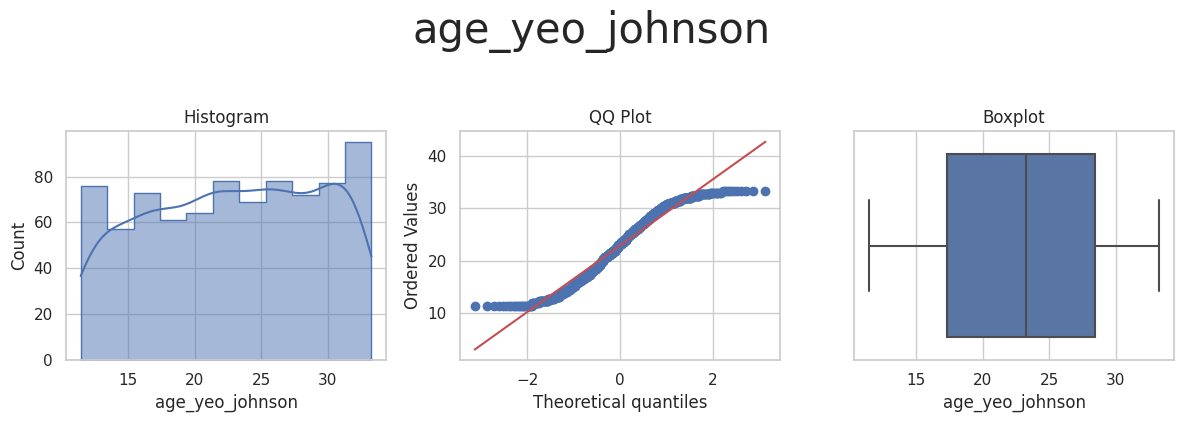



* Variable Analyzed: restingBP
* Applied transformation: ['restingBP_log_e', 'restingBP_log_10', 'restingBP_reciprocal', 'restingBP_power', 'restingBP_box_cox', 'restingBP_yeo_johnson'] 



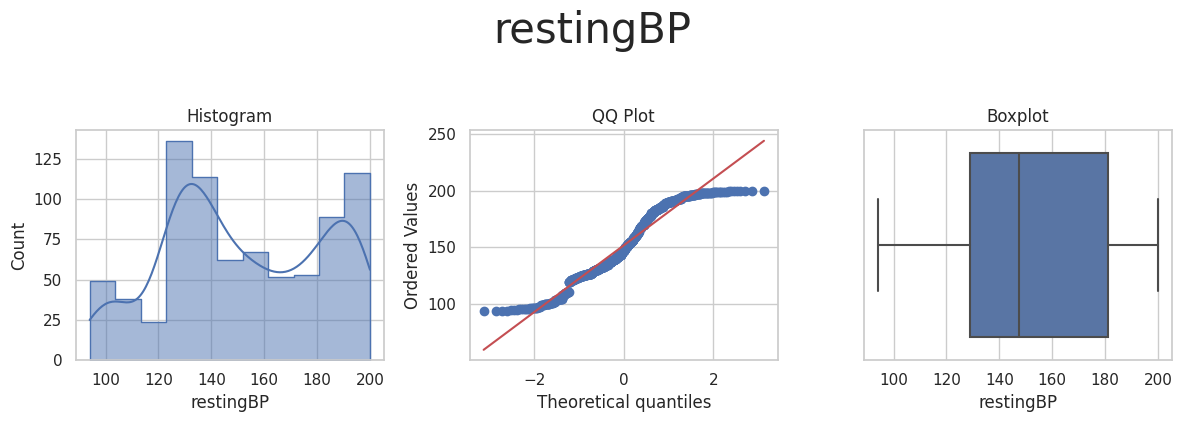

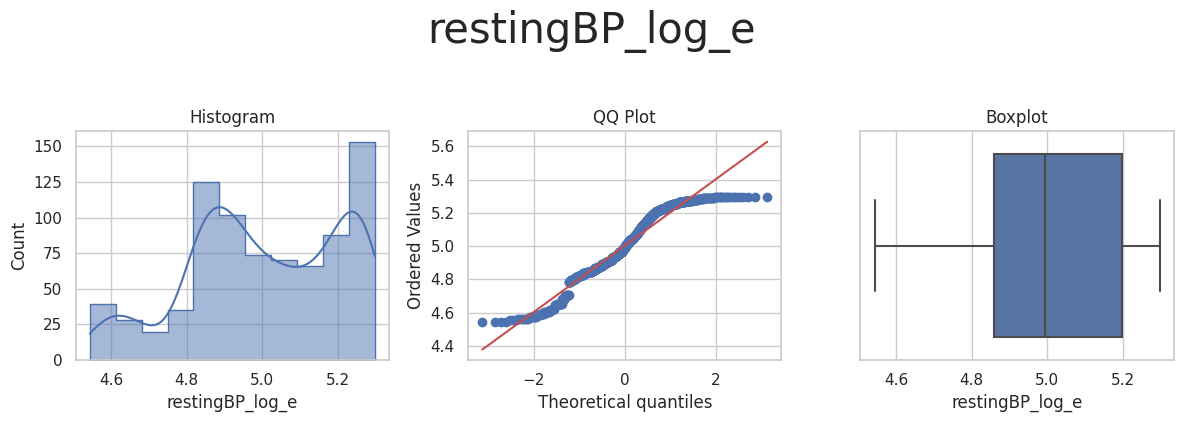

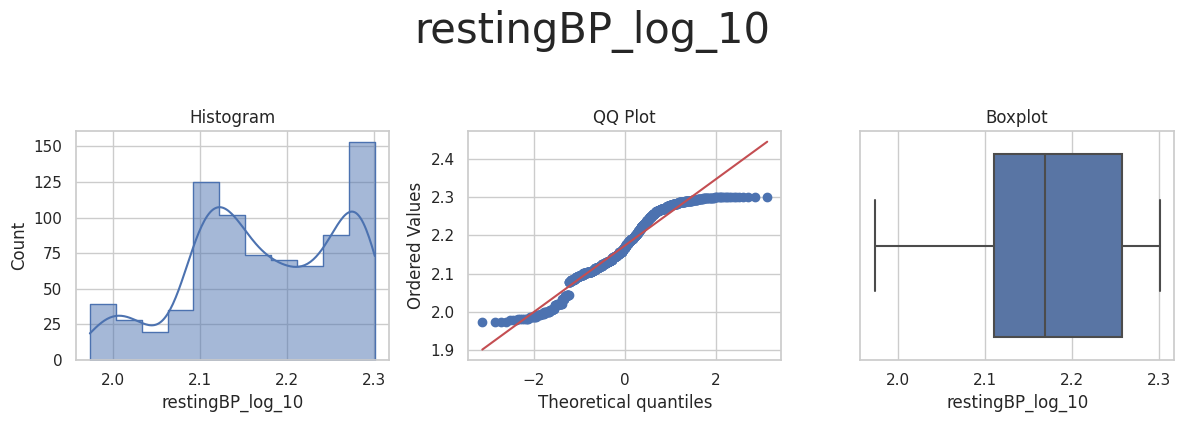

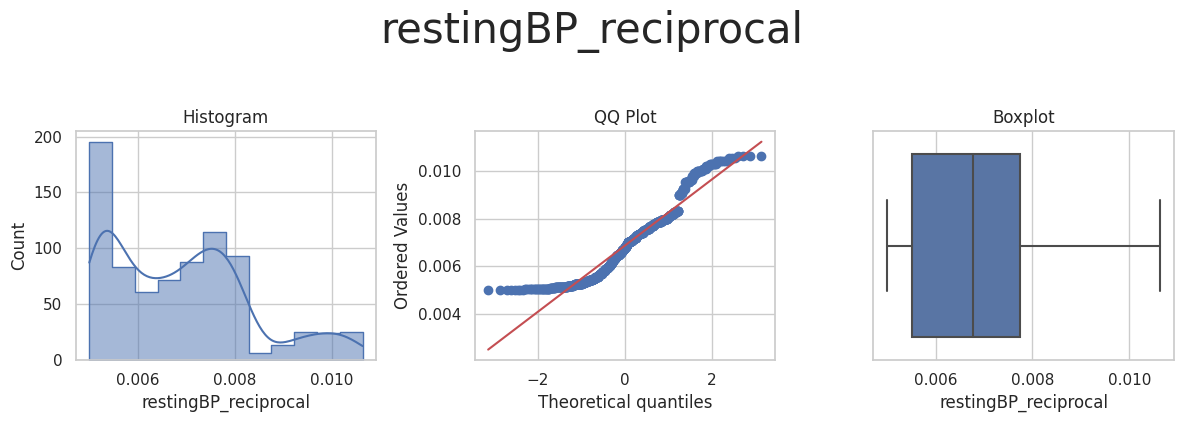

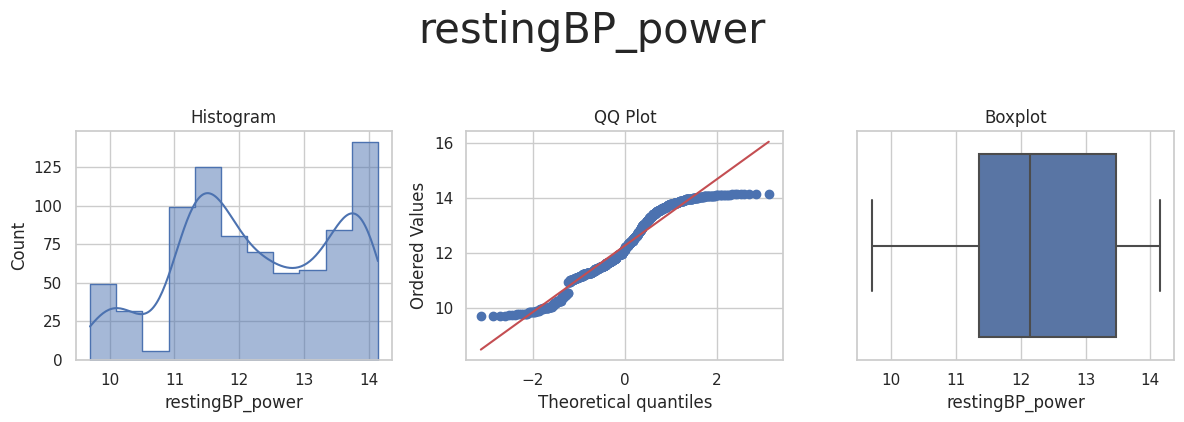

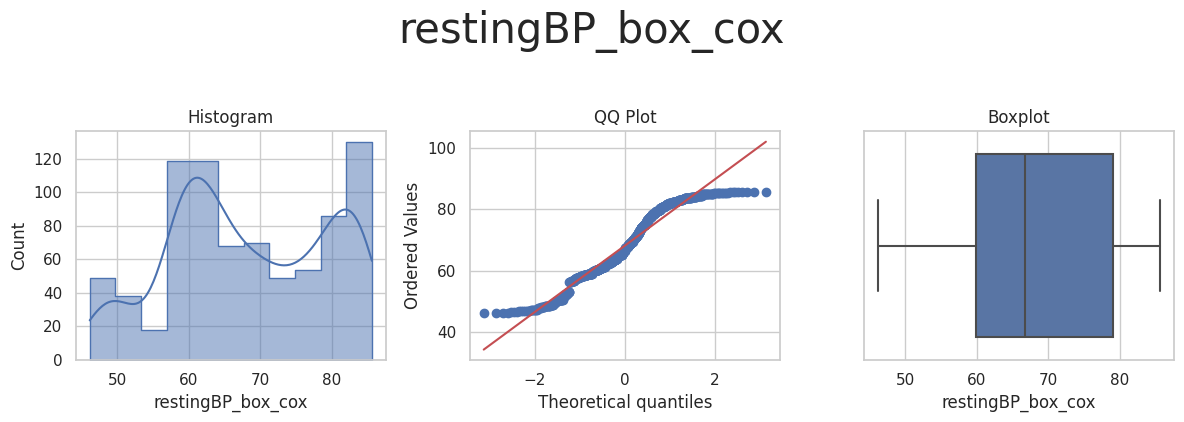

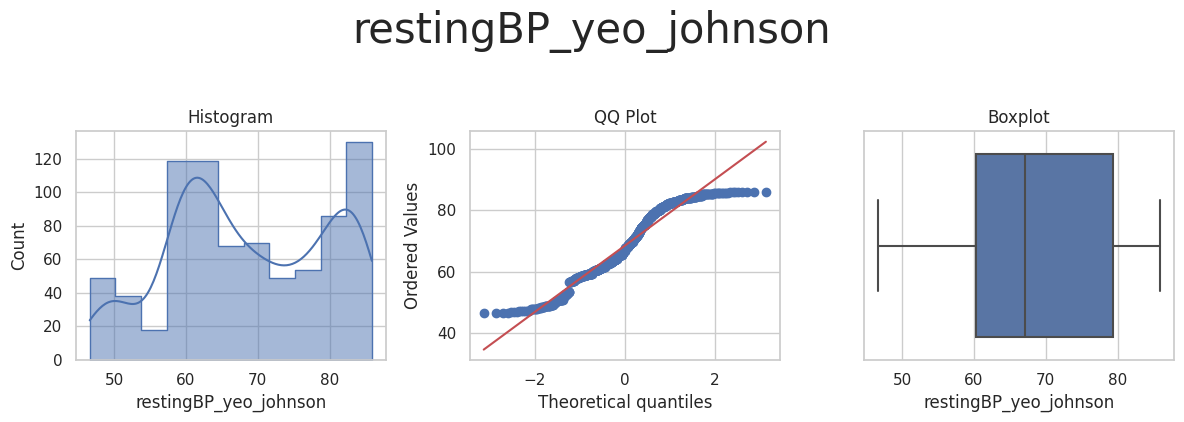



* Variable Analyzed: serumcholestrol
* Applied transformation: ['serumcholestrol_log_e', 'serumcholestrol_log_10', 'serumcholestrol_reciprocal', 'serumcholestrol_power', 'serumcholestrol_box_cox', 'serumcholestrol_yeo_johnson'] 



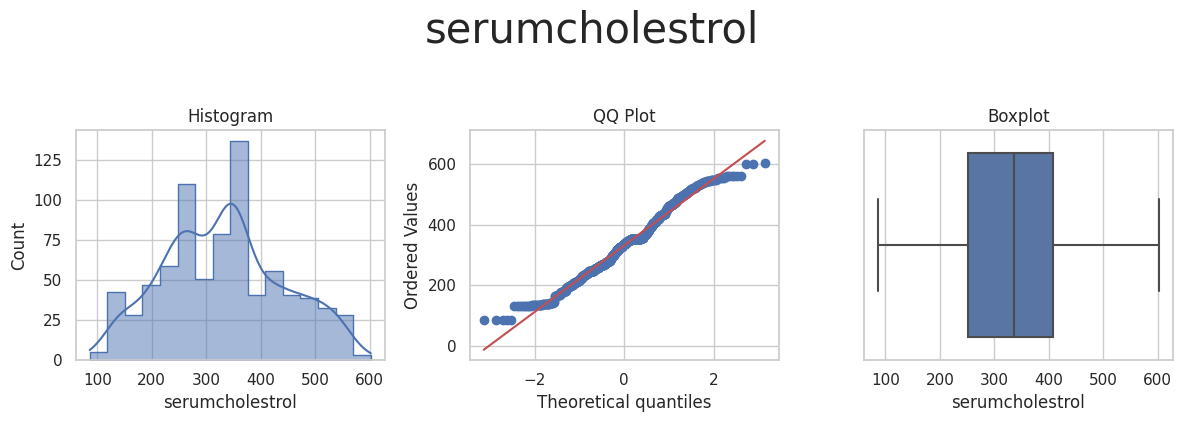

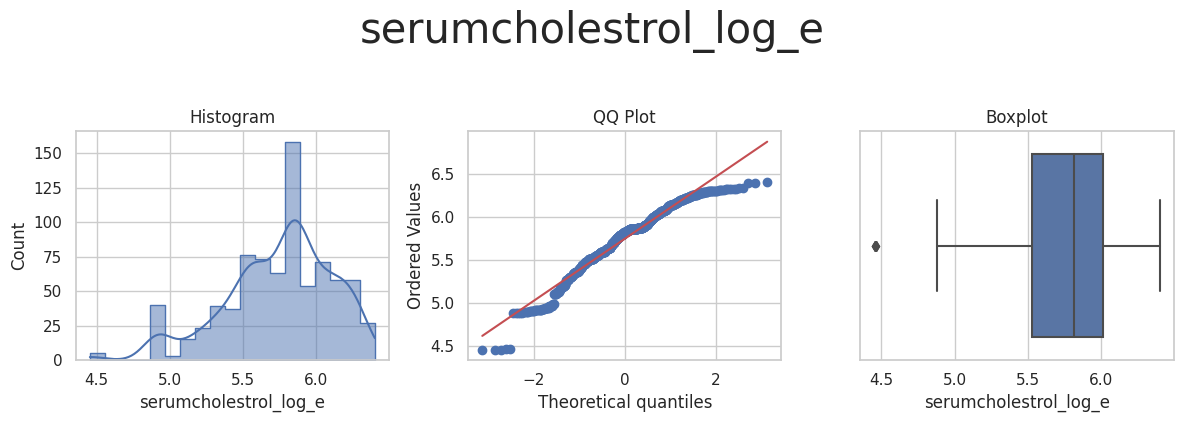

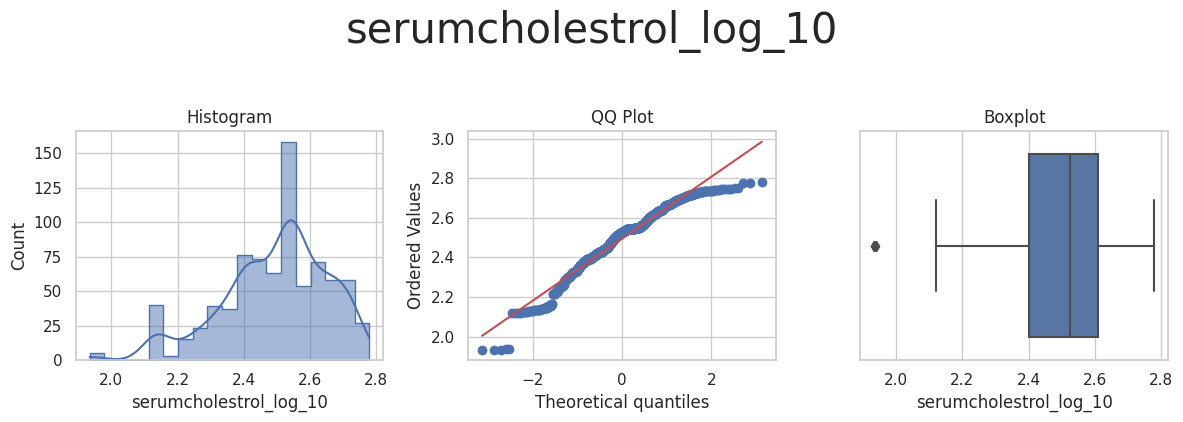

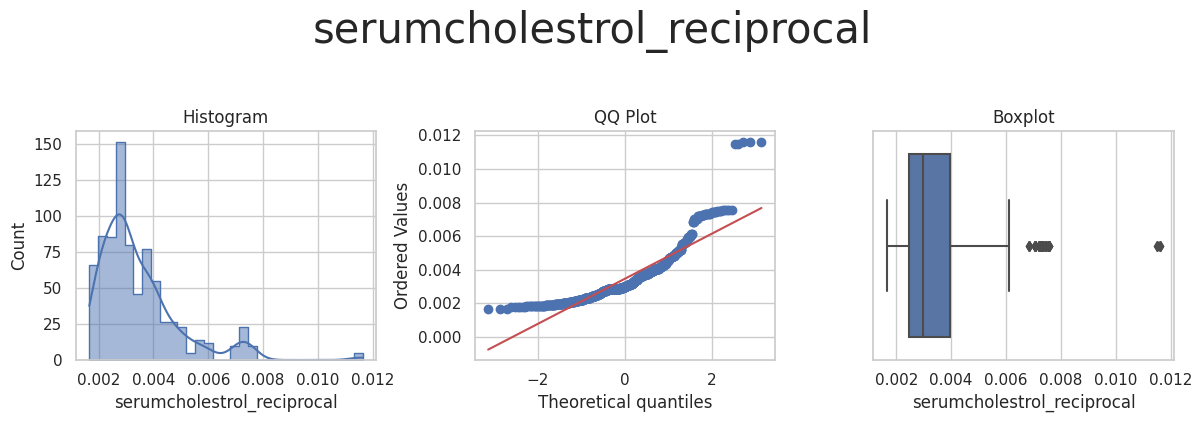

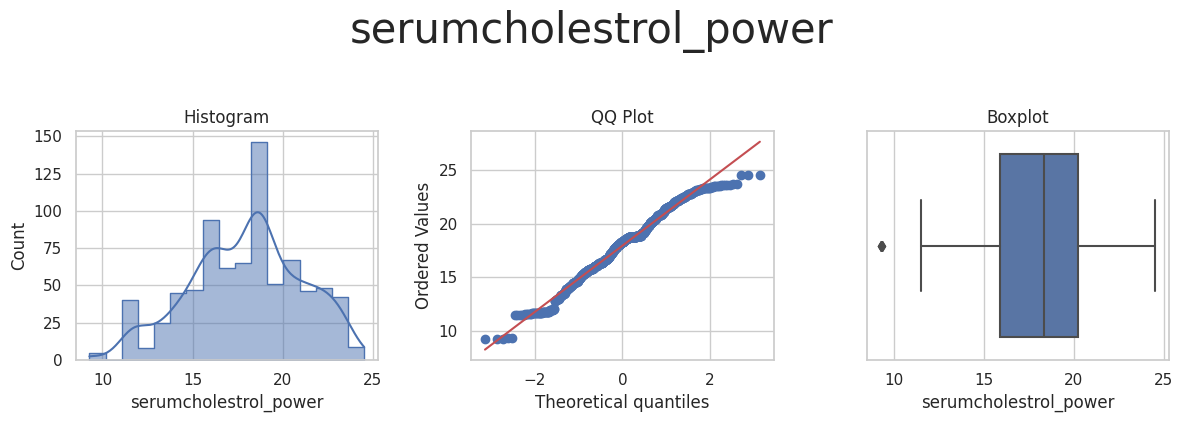

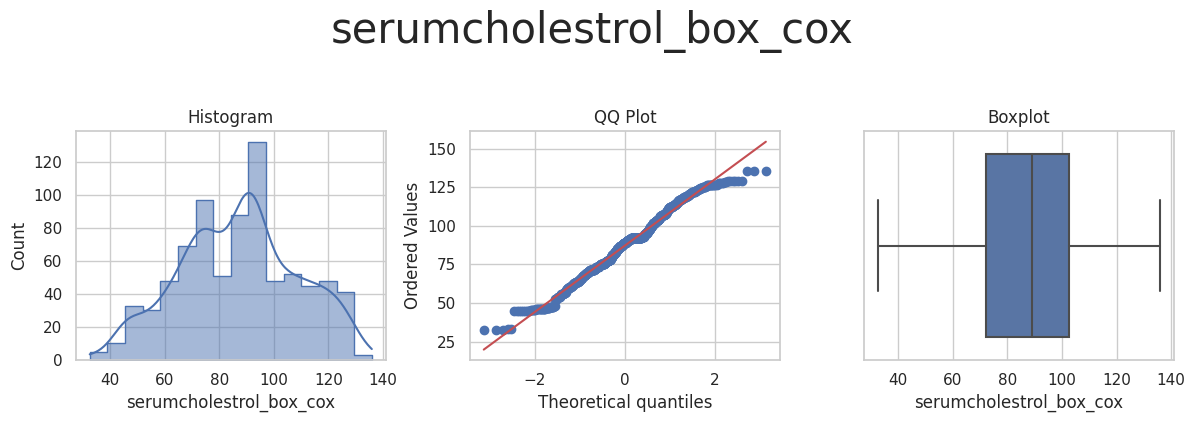

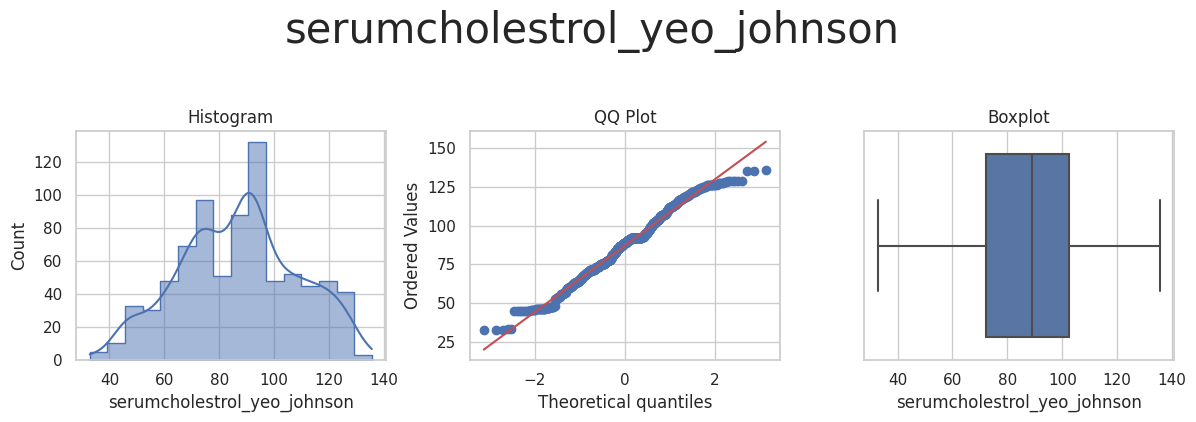



* Variable Analyzed: maxheartrate
* Applied transformation: ['maxheartrate_log_e', 'maxheartrate_log_10', 'maxheartrate_reciprocal', 'maxheartrate_power', 'maxheartrate_box_cox', 'maxheartrate_yeo_johnson'] 



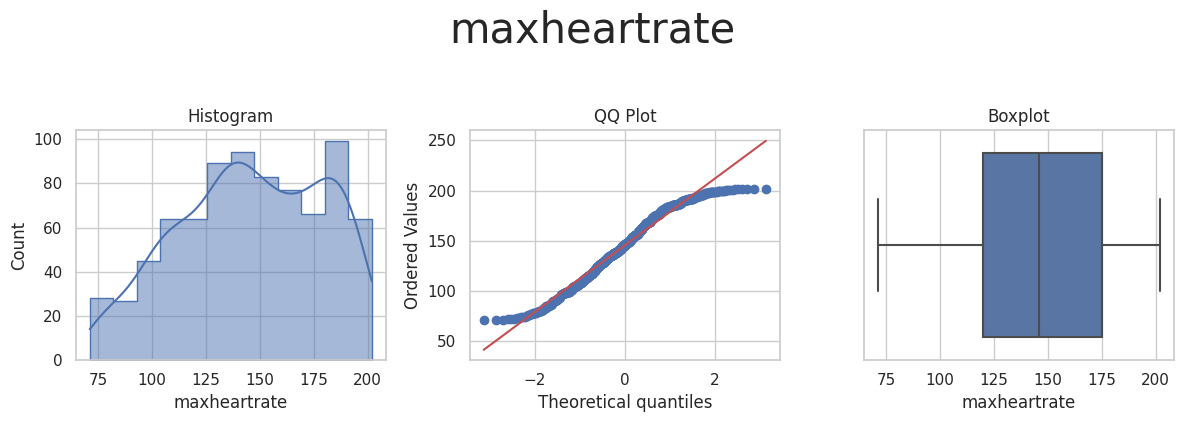

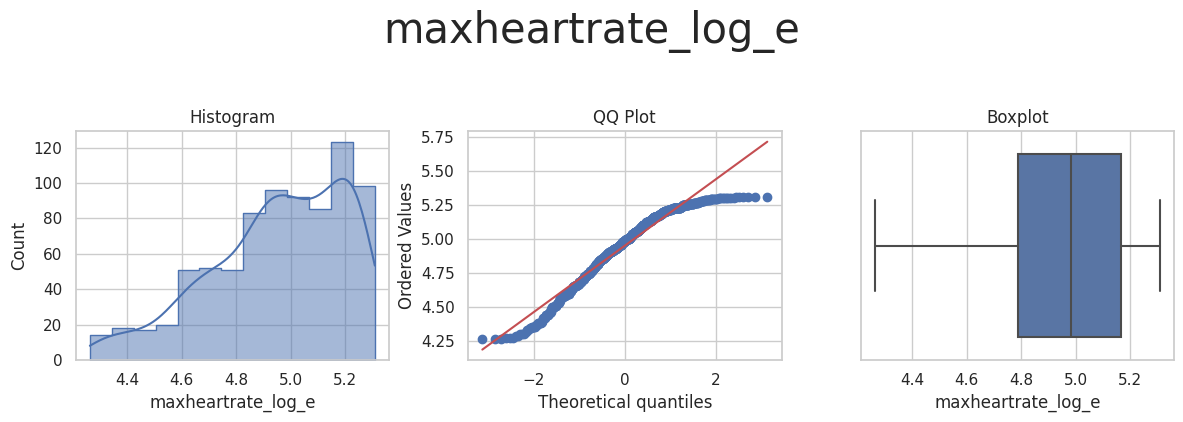

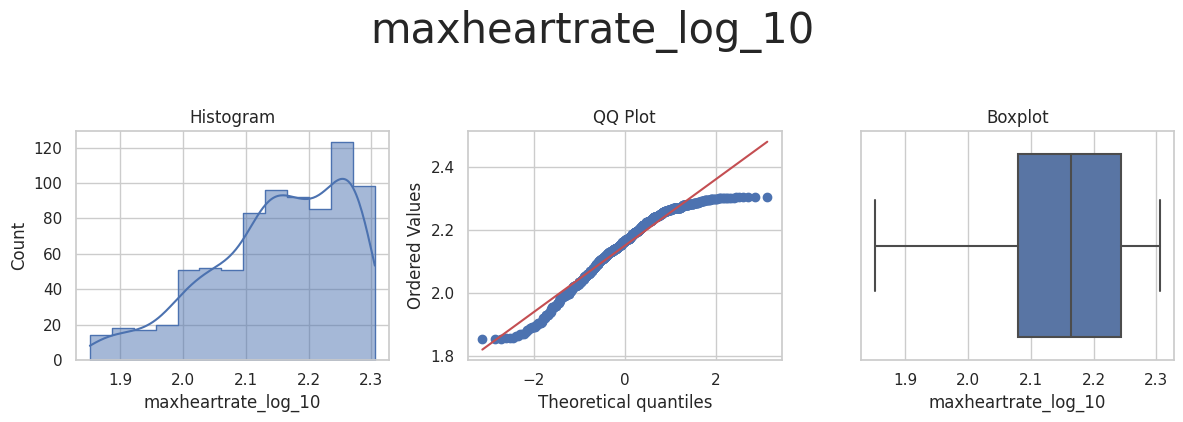

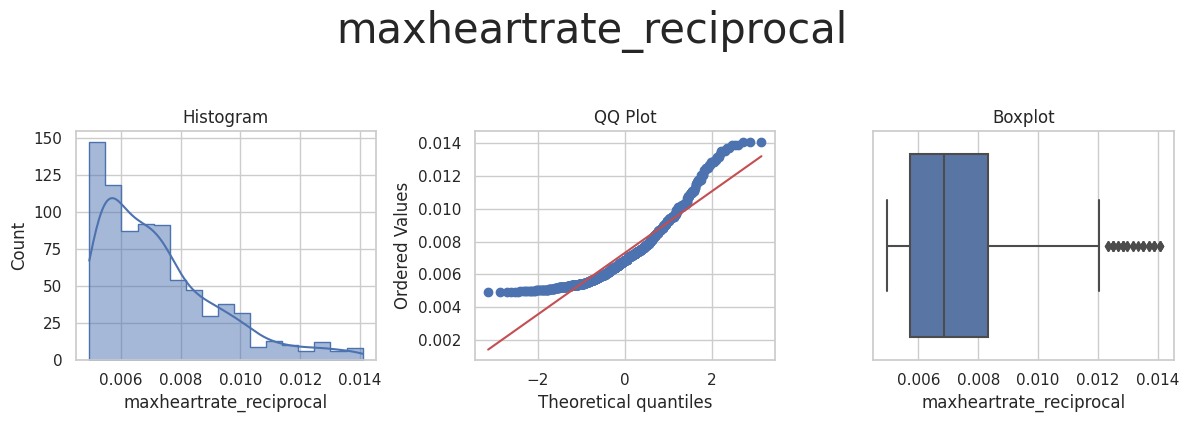

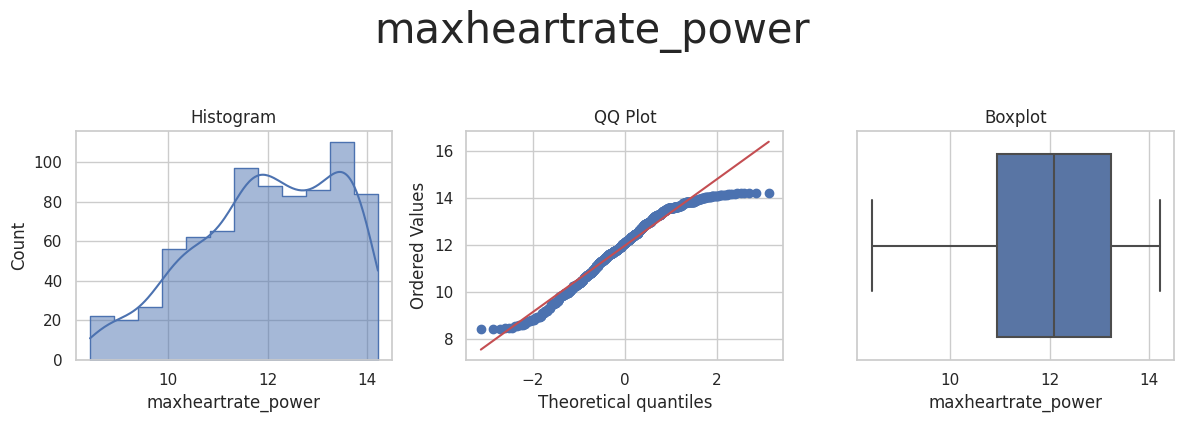

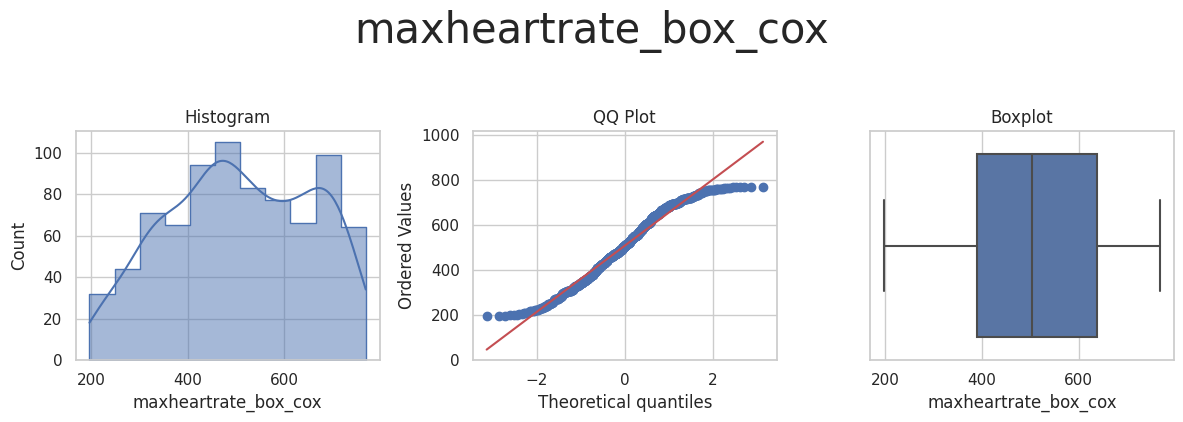

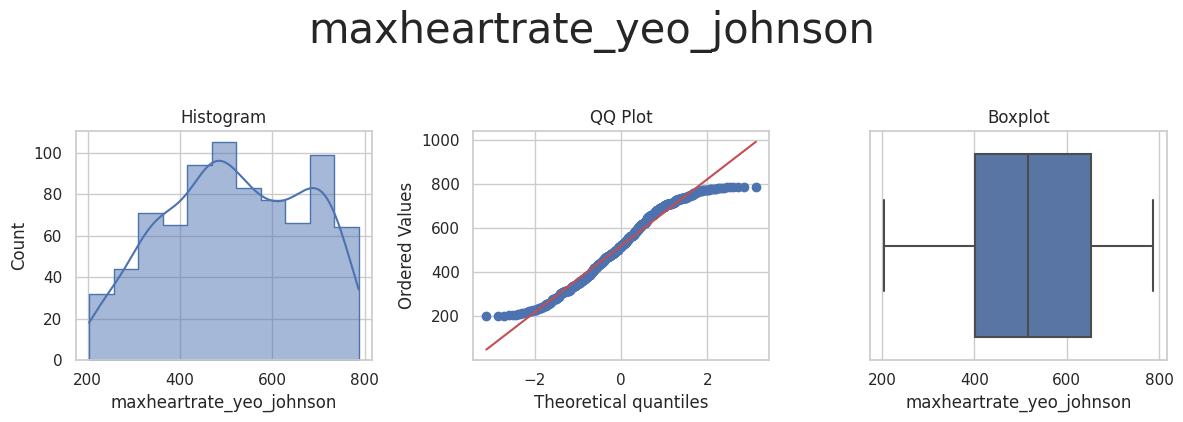



* Variable Analyzed: oldpeak
* Applied transformation: ['oldpeak_power', 'oldpeak_yeo_johnson'] 



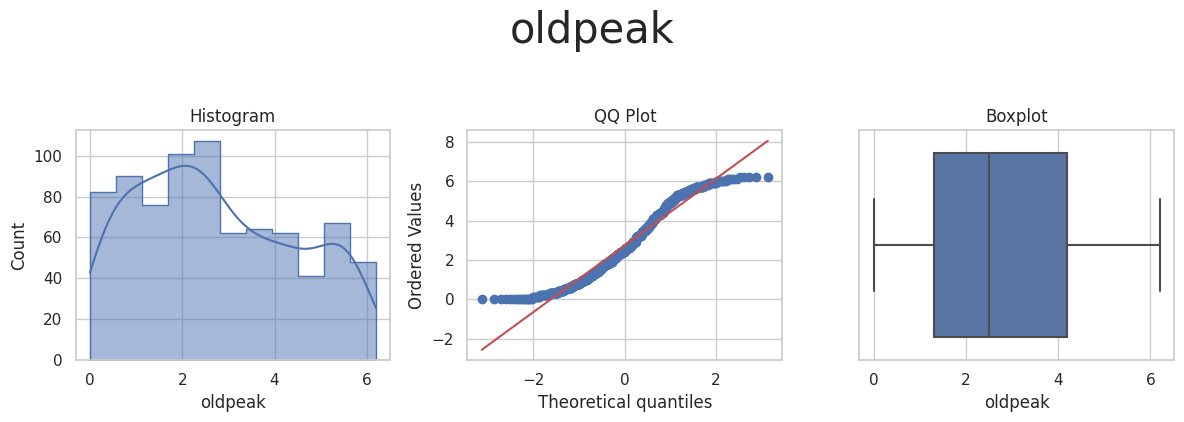

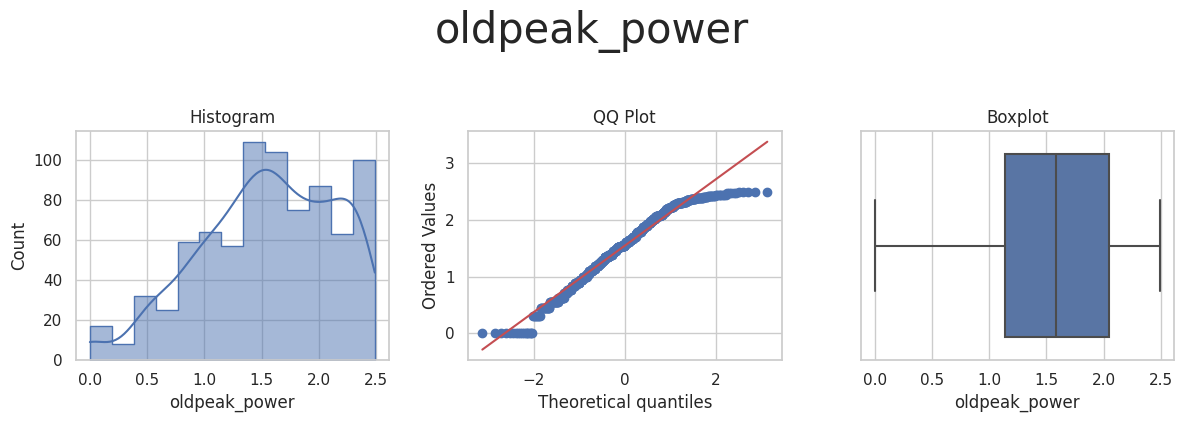

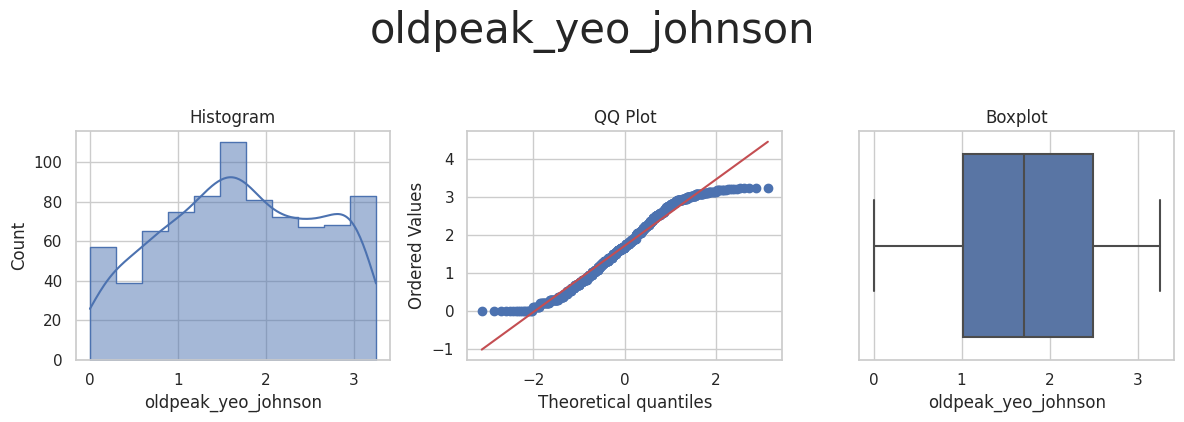



* Variable Analyzed: noofmajorvessels
* Applied transformation: ['noofmajorvessels_power', 'noofmajorvessels_yeo_johnson'] 



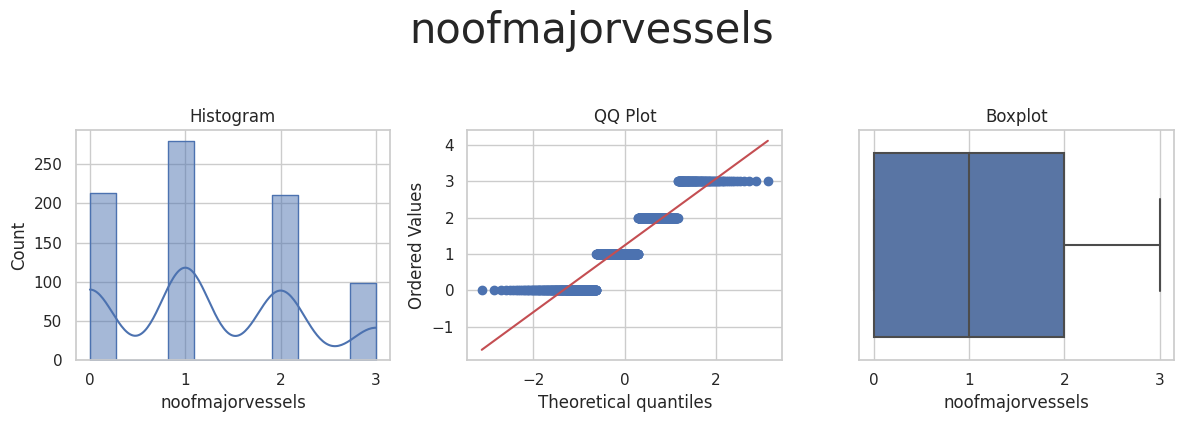

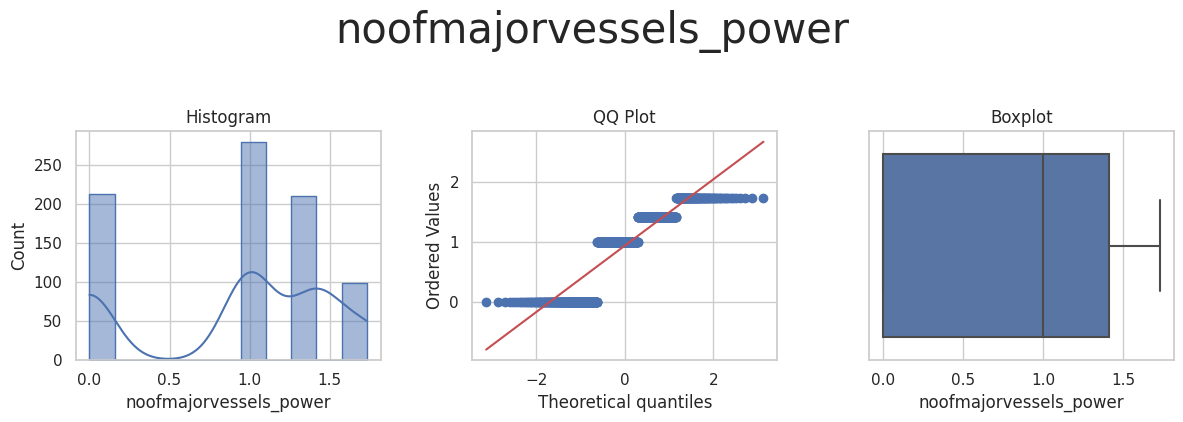

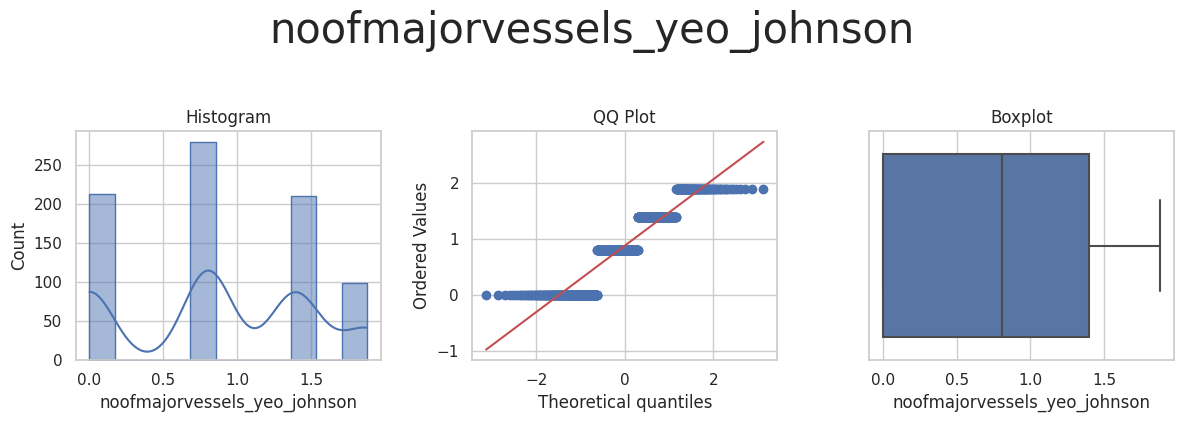

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

<img src="../static/images/transformation-table.png" alt="feature engineering transformation table" height="200" />

NOTES:
* We will use yeo-johnson transformer for 'serumcholestrol' 'maxheartrate' and 'oldpeak' variables

* Other variables didn't show significant improvement with any of the transformers

* Step 4 - Apply the selected transformation to the Train and Test set

In [11]:
encoder = vt.YeoJohnsonTransformer(variables = [
    'maxheartrate', 
    'serumcholestrol', 
    'oldpeak', ])
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("Numerical encoding - log e transformation done!")

Numerical encoding - log e transformation done!


---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
